# Osmosis synthetic data backtesting example

This is an example notebook how to backtest trading strategies on [Osmosis Cosmos DEX](https://osmosis.zone/).
It is based on work done in [HackAtom Seoul 2022 hackathon](https://www.buidl.asia/hackatom-seoul-2022).

Some highlights of this notebook:

* [Backtest Osmosis manually extracted data](https://github.com/tradingstrategy-ai/hackatom-2022-osmosis-algorithmic-trading-solution)
* ATOM/OSMO pair
* Hourly OHCLV candles
* Uses simple overfitted EMA strategy (not realistic profits)

## Set up

Set up strategy paramets that will decide its behavior

In [1]:
import datetime
import logging

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import TradeRouting, ReserveCurrency

# Rebalance every 8h
trading_strategy_cycle = CycleDuration.cycle_8h

# How much of the cash to put on a single trade
position_size = 0.90

candle_time_bucket = TimeBucket.h1

chain_id = ChainId.osmosis

#
# Strategy thinking specific parameter
#

# 14 days
slow_ema_candle_count = 14*24

# 5 days
fast_ema_candle_count = 5*24

# How many candles to extract from the dataset once
batch_size = slow_ema_candle_count * 2

# Range of backtesting and synthetic data generation.
# Because we are using synthetic data actual dates do not really matter -
# only the duration

# Osmosis launched
# generate a few months of data before strategy start

start_at_data = datetime.datetime(2021, 12, 25)
start_at_strategy = datetime.datetime(2022, 4, 25)

# When our data and strategy ends
end_at = datetime.datetime(2022, 7, 25)


### Create our fake exchange and pair

This will be needed to generate the candles with the same `pair_id`, and also later, when we generate our synthetic universe

In [2]:
import random
from tradeexecutor.testing.synthetic_pair_data import generate_pair
from tradeexecutor.testing.synthetic_ethereum_data import generate_random_ethereum_address
from tradeexecutor.testing.synthetic_exchange_data import generate_exchange

pair_id = 1

exchange = generate_exchange(
        exchange_id=random.randint(1, 1000),
        chain_id=chain_id,
        address=generate_random_ethereum_address(),
    )

pair = generate_pair(exchange, symbol0="ATOM", symbol1="OSMO", internal_id=pair_id)


### Create our candles

#### Bullish data

For the purposes of this notebook, we have created bullish data, this was achieved by slightly skewing the `daily_drift` argument to the right of 1. Notice how it is 2% above 1 but 1.95% below 1. 

#### Bearish data

Try skewing to the left for bearish data. I.e:

`daily_drift = (0.98, 1.0195)`

### Ranging

No skew for sideways data! I.e.:

`daily_drift = (0.98, 1.02)`

### Volatility

Experiment with the `high_drift` and `low_drift` parameters to adjust the volatility

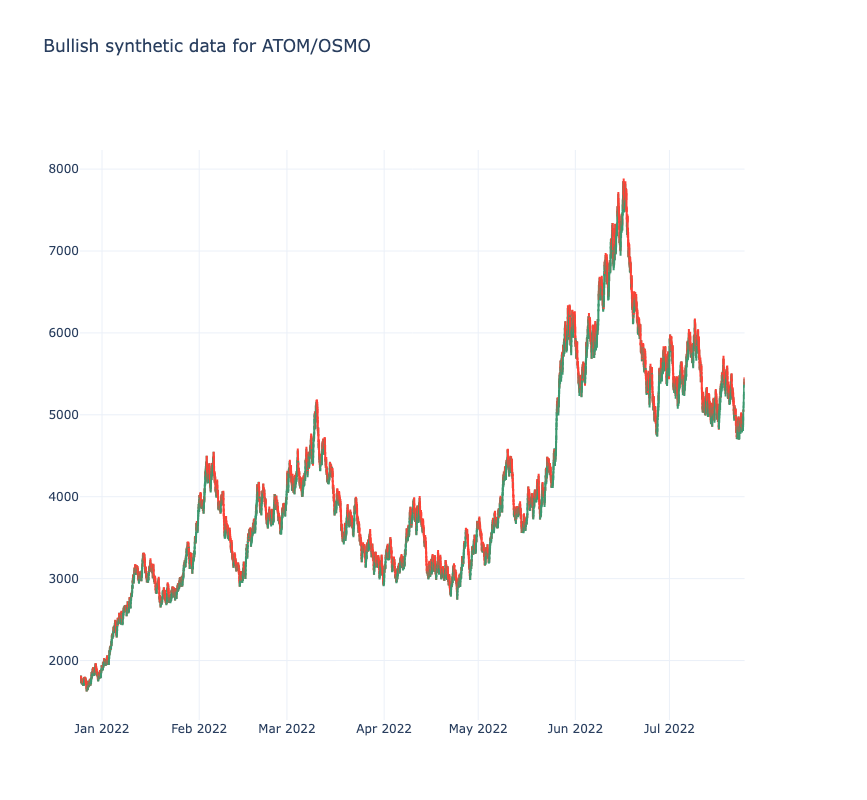

In [3]:
# Create our candles
from tradeexecutor.testing.synthetic_price_data import generate_ohlcv_candles
from tradingstrategy.charting.candle_chart import visualise_ohlcv
import pandas as pd

candles = generate_ohlcv_candles(
    start=start_at_data, 
    end=end_at, 
    bucket=candle_time_bucket,
    pair_id = pair.internal_id,
    exchange_id=exchange.exchange_id,
    daily_drift=(0.9805, 1.02),  # bullish
    # daily_drift = (0.98, 1.0195),  # bearish
    # daily_drift = (0.98, 1.02),  # sideways
    high_drift=1.01,
    low_drift=0.99,
)

visualise_ohlcv(candles, chart_name="Bullish synthetic data for ATOM/OSMO", y_axis_name="Price (USD)")


## Strategy logic and trade decisions

`decide_trades` function decide what trades to take.
In this example, we calculate two exponential moving averages
(EMAs) and make decisions based on those.

In [4]:
from typing import List, Dict

from pandas_ta.overlap import ema

from tradingstrategy.universe import Universe

from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State

def decide_trades(
        timestamp: pd.Timestamp,
        universe: Universe,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:
    """The brain function to decide the trades on each trading strategy cycle."""

    # The pair we are trading
    pair = universe.pairs.get_single()

    assert pair.token0_symbol == "ATOM", f"Got pair {pair}"
    assert pair.token1_symbol == "OSMO", f"Got pair {pair}"

    # How much cash we have in the hand
    cash = state.portfolio.get_current_cash()

    # Get OHLCV candles for our trading pair as Pandas Dataframe.
    # We could have candles for multiple trading pairs in a different strategy,
    # but this strategy only operates on single pair candle.
    # We also limit our sample size to N latest candles to speed up calculations.
    candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=batch_size)

    # We have data for open, high, close, etc.
    # We only operate using candle close values in this strategy.
    close = candles["close"]

    # Calculate exponential moving averages based on slow and fast sample numbers.
    # https://github.com/twopirllc/pandas-ta
    # https://github.com/twopirllc/pandas-ta/blob/bc3b292bf1cc1d5f2aba50bb750a75209d655b37/pandas_ta/overlap/ema.py#L7
    slow_ema_series = ema(close, length=slow_ema_candle_count)
    fast_ema_series = ema(close, length=fast_ema_candle_count)

    if slow_ema_series is None or fast_ema_series is None:
        # Cannot calculate EMA, because
        # not enough samples in backtesting
        return []

    slow_ema = slow_ema_series.iloc[-1]
    fast_ema = fast_ema_series.iloc[-1]

    # Get the last close price from close time series
    # that's Pandas's Series object
    # https://pandas.pydata.org/docs/reference/api/pandas.Series.iat.html
    current_price = close.iloc[-1]

    # List of any trades we decide on this cycle.
    # Because the strategy is simple, there can be
    # only zero (do nothing) or 1 (open or close) trades
    # decides
    trades = []

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, universe, state, pricing_model)
    
    if not position_manager.is_any_open():
        if current_price >= slow_ema:
        # Entry condition:
        # Close price is higher than the slow EMA
            buy_amount = cash * position_size
            trades += position_manager.open_1x_long(pair, buy_amount)
    else:
        if slow_ema >= fast_ema:
        # Exit condition:
        # Fast EMA crosses slow EMA
            trades += position_manager.close_all()

    # Visualize strategy
    # See available Plotly colours here
    # https://community.plotly.com/t/plotly-colours-list/11730/3?u=miohtama
    visualisation = state.visualisation
    visualisation.plot_indicator(timestamp, "Slow EMA", PlotKind.technical_indicator_on_price, slow_ema, colour="darkblue")
    visualisation.plot_indicator(timestamp, "Fast EMA", PlotKind.technical_indicator_on_price, fast_ema, colour="#003300")

    return trades

## Defining trading universe

We create a trading universe with a single blockchain, exchange and trading pair.
For the sake of easier understanding the code, we name this "Uniswap v2" like exchange with a single ETH-USDC trading pair.

The trading pair contains generated noise-like OHLCV trading data.

In [5]:
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.testing.synthetic_universe_data import create_synthetic_single_pair_universe

def create_trading_universe() -> TradingStrategyUniverse:

    trading_strategy_universe = create_synthetic_single_pair_universe(
        candles, 
        chain_id,
        exchange,
        candle_time_bucket,
        pair,
    )

    return trading_strategy_universe



## Running the backtest

Run backtest using giving trading universe and strategy function.

Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.

In [6]:
from tradeexecutor.testing.synthetic_exchange_data import generate_simple_routing_model
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

universe = create_trading_universe()

start_candle, end_candle = universe.universe.candles.get_timestamp_range()
print(f"Our universe has synthetic candle data for the period {start_candle} - {end_candle}")

# This function set ups trade routing for our synthetic trading universe.
# Because we have only one trading pair, there is no complicated
# routing needed
routing_model = generate_simple_routing_model(universe)

state, universe,    debug_dump = run_backtest_inline(
    name="ATOM/OSMO backtest",
    start_at=start_at_strategy,
    end_at=end_at,
    client=None,  # None of downloads needed, because we are using synthetic data
    cycle_duration=trading_strategy_cycle,  # Override to use 24h cycles despite what strategy file says
    decide_trades=decide_trades,
    universe=universe,
    initial_deposit=10_000,
    reserve_currency=ReserveCurrency.busd,
    trade_routing=TradeRouting.user_supplied_routing_model,
    routing_model=routing_model,
    log_level=logging.WARNING,
)


Our universe has synthetic candle data for the period 2021-12-25 00:00:00 - 2022-07-24 23:00:00


  0%|          | 0/7862400 [00:00<?, ?it/s]

## Examine backtest results

Examine `state` that contains all actions the trade executor took.

We plot out a chart that shows
- The price action
- When the strategy made buys or sells

In [7]:
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")
print(f"Visualisation entries: {len(list(state.visualisation.plots))}")

Positions taken: 15
Trades made: 30
Visualisation entries: 2


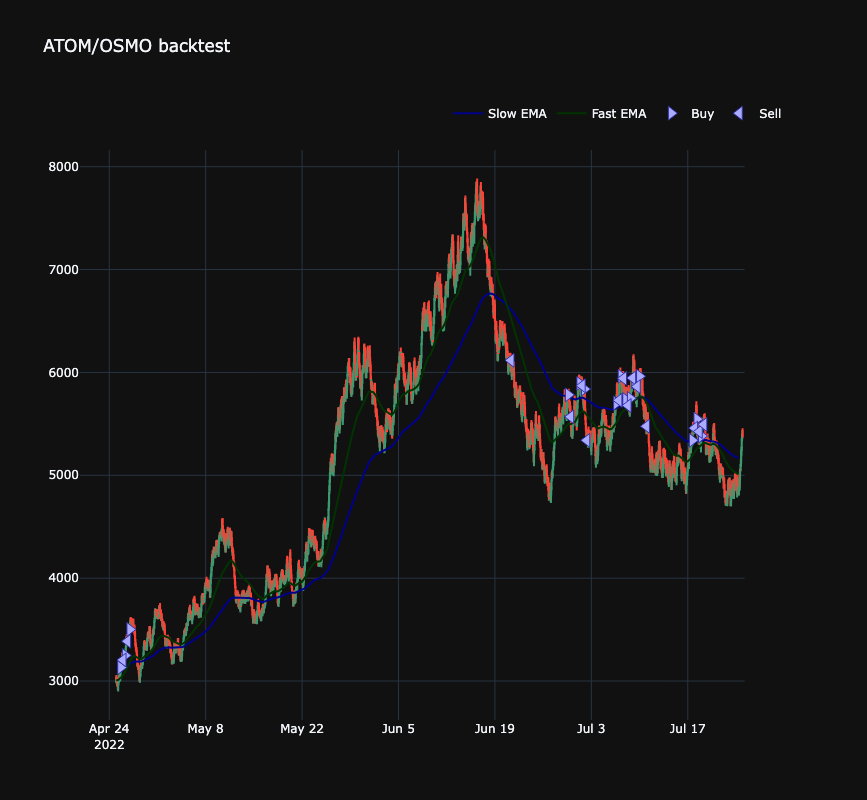

In [8]:
from tradeexecutor.visual.single_pair import visualise_single_pair

figure = visualise_single_pair(state, universe.universe.candles, start_at=start_at_strategy)
figure.update_layout(template="plotly_dark")  # Dark color theme https://plotly.com/python/templates/
figure.show()

### Equity curve and drawdown

Visualise equity curve and related performnace over time.

- Returns

- Drawdown

- Daily returns

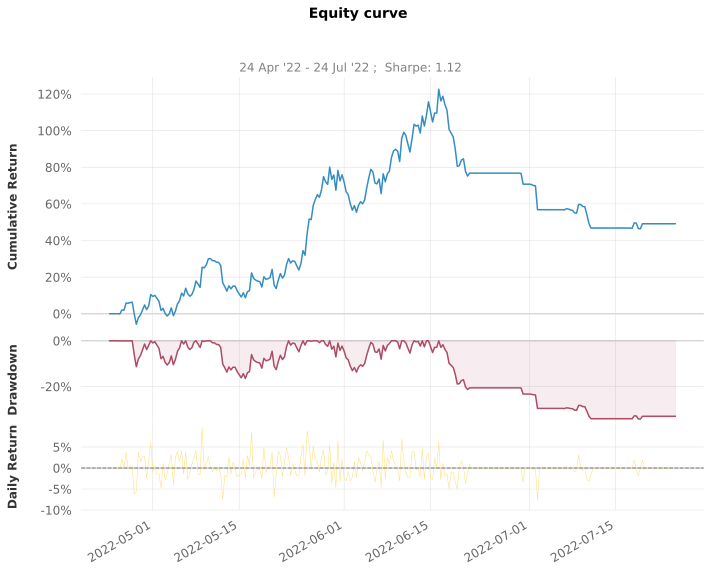

In [9]:
# Set Jupyter Notebook output mode parameters
# Used to avoid warnings
from tradeexecutor.backtest.notebook import setup_charting_and_output
setup_charting_and_output()

# Needed to improve the resolution of matplotlib chart used here
%config InlineBackend.figure_format = 'svg'

from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
visualise_equity_curve(returns)

### Returns monthly breakdown

- Monthly returns
- Best day/week/month/year

/usr/local/lib/python3.10/site-packages/quantstats/stats.py:968: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



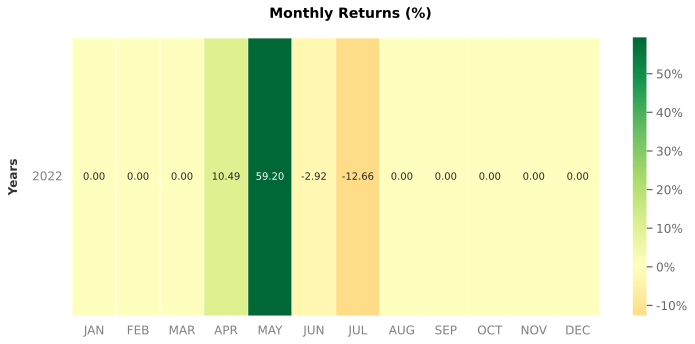

In [10]:
from tradeexecutor.visual.equity_curve import visualise_returns_over_time

visualise_returns_over_time(returns)

## Benchmarking the strategy performance

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold US dollar
- Buy and hold the underlying trading pair base asset


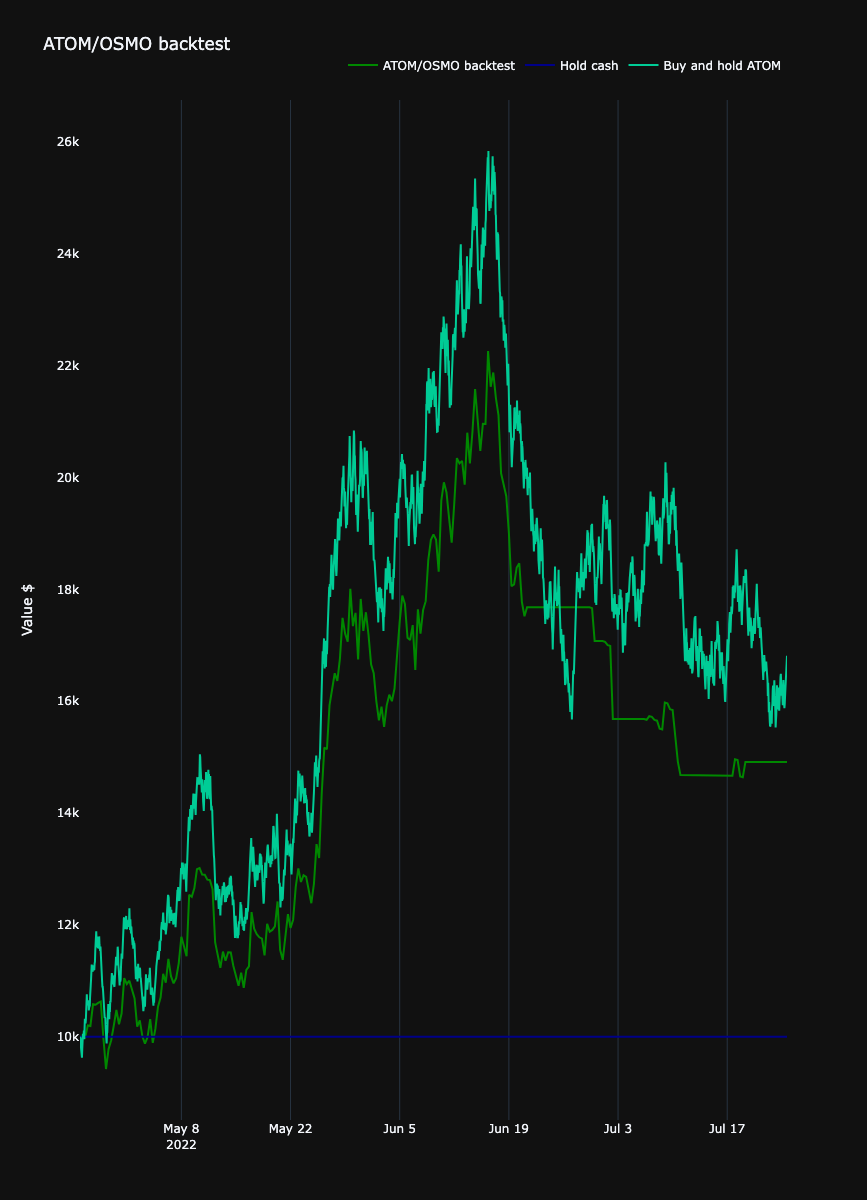

In [11]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
)

fig.update_layout(template="plotly_dark")  # Dark color theme https://plotly.com/python/templates/
fig.show()

## Analysing  the strategy success

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [12]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Strategy summary

Overview of strategy performance



In [13]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics()

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

0
Trading period length                       84 days
Return %                                     49.15%
Annualised return %                         211.88%
Cash at start                            $10,000.00
Value at end                             $14,914.74
Trade volume                            $403,209.29
Position win percent                         46.67%
Total positions                                  15
Won positions                                     7
Lost positions                                    8
Stop losses triggered                             0
Stop loss % of all                            0.00%
Stop loss % of lost                           0.00%
Winning stop losses                               0
Winning stop losses percent                       -
Losing stop losses                                0
Losing stop losses percent                        -
Take profits triggered                            0
Take profit % of all                          0.00%
Take profit % of won                          0.00%
Zero profit positions                             0
Positions open at the end                         0
Realised profit and loss                  $4,914.74
Portfolio unrealised value                    $0.00
Extra returns on lending pool interest        $0.00
Cash left at the end                     $14,914.74
Average winning position profit %            12.68%
Average losing position loss %               -3.23%
Biggest winning position %                   74.53%
Biggest losing position %                    -8.64%
Average duration of winning positions        8 days
Average duration of losing positions         0 days
LP fees paid                                $201.66
LP fees paid % of volume                      0.05%
Average position:                             4.19%
Median position:                             -0.48%
Most consecutive wins                             3
Most consecutive losses                           3
Biggest realized risk                        -7.78%
Avg realised risk                            -2.91%
Max pullback of total capital               -12.74%
Max loss risk at opening of position         90.00%

### Performance metrics

Here is an example how to use Quantstats library to calculate the tearsheet metrics for the strategy with advanced metrics. The metrics include popular risk-adjusted return comparison metrics.

This includes metrics like:

- Sharpe
- Sortino
- Max drawdown

**Note:** These metrics are based on equity curve and returns. Analysis here does not go down to the level of an individual trade or a position. Any consecutive wins and losses are measured in days, not in trade or candle counts.

In [14]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.analysis.advanced_metrics import visualise_advanced_metrics, AdvancedMetricsMode

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)
metrics = visualise_advanced_metrics(returns, mode=AdvancedMetricsMode.full)

with pd.option_context("display.max_row", None):
    display(metrics)

Strategy
Start Period               2022-04-25
End Period                 2022-07-24
Risk-Free Rate                   0.0%
Time in Market                  73.0%
Cumulative Return              49.15%
CAGR﹪                         405.95%
Sharpe                           1.35
Prob. Sharpe Ratio             88.12%
Smart Sharpe                     1.28
Sortino                          2.17
Smart Sortino                    2.06
Sortino/√2                       1.53
Smart Sortino/√2                 1.46
Omega                            1.24
Max Drawdown                  -34.23%
Longest DD Days                    38
Volatility (ann.)              48.27%
Calmar                          11.86
Skew                             0.46
Kurtosis                         1.93
Expected Daily                  0.15%
Expected Monthly               10.51%
Expected Yearly                49.15%
Kelly Criterion                 8.72%
Risk of Ruin                     0.0%
Daily Value-at-Risk            -3.98%
Expected Shortfall (cVaR)      -3.98%
Max Consecutive Wins                5
Max Consecutive Losses              8
Gain/Pain Ratio                  0.44
Gain/Pain (1M)                   3.63
Payoff Ratio                     1.54
Profit Factor                    1.24
Common Sense Ratio               1.76
CPC Index                        0.85
Tail Ratio                       1.42
Outlier Win Ratio                4.89
Outlier Loss Ratio               3.46
MTD                           -12.66%
3M                             49.15%
6M                             49.15%
YTD                            49.15%
1Y                             49.15%
3Y (ann.)                     405.95%
5Y (ann.)                     405.95%
10Y (ann.)                    405.95%
All-time (ann.)               405.95%
Best Day                        9.63%
Worst Day                      -7.69%
Best Month                      59.2%
Worst Month                   -12.66%
Best Year                      49.15%
Worst Year                     49.15%
Avg. Drawdown                  -5.69%
Avg. Drawdown Days                  3
Recovery Factor                  1.44
Ulcer Index                      0.19
Serenity Index                   0.19
Avg. Up Month                  34.85%
Avg. Down Month                -7.79%
Win Days                       44.67%
Win Month                       50.0%
Win Quarter                     50.0%
Win Year                       100.0%

### Position and trade timeline

Display all positions and how much profit they made.



In [15]:
from tradeexecutor.analysis.trade_analyser import expand_timeline

timeline = analysis.create_timeline()

expanded_timeline, apply_styles = expand_timeline(
        universe.universe.exchanges,
        universe.universe.pairs,
        timeline)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))


## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [16]:
print("All ok")

All ok
